In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
#Read the csv file
df = pd.read_csv('ORCL_historical_data.csv')
print(len(df))
print(df.head()) #7 columns, including the Date. 


251
         Date       Open       High        Low      Close  Adj Close    Volume
0  2022-01-26  81.910004  82.029999  79.279999  79.589996  78.229874  13971300
1  2022-01-27  80.110001  81.150002  79.199997  79.779999  78.416634  10331900
2  2022-01-28  79.989998  80.500000  78.570000  80.480003  79.104668   7854700
3  2022-01-31  80.489998  81.639999  80.120003  81.160004  79.773056  10594200
4  2022-02-01  81.400002  81.400002  79.650002  81.040001  79.655098   8016900


In [7]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

236   2023-01-04
237   2023-01-05
238   2023-01-06
239   2023-01-09
240   2023-01-10
241   2023-01-11
242   2023-01-12
243   2023-01-13
244   2023-01-17
245   2023-01-18
246   2023-01-19
247   2023-01-20
248   2023-01-23
249   2023-01-24
250   2023-01-25
Name: Date, dtype: datetime64[ns]
['Open', 'High', 'Low', 'Close', 'Adj Close']


In [8]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [31]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1 # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [32]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
14/14 [==============================] - 0s 22ms/step - loss: 0.0380 - val_loss: 0.0336
Epoch 2/5
14/14 [==============================] - 0s 21ms/step - loss: 0.0435 - val_loss: 0.0157
Epoch 3/5
14/14 [==============================] - 0s 22ms/step - loss: 0.0437 - val_loss: 0.0205
Epoch 4/5
14/14 [==============================] - 0s 21ms/step - loss: 0.0456 - val_loss: 0.0700
Epoch 5/5
14/14 [==============================] - 0s 20ms/step - loss: 0.0470 - val_loss: 0.0343


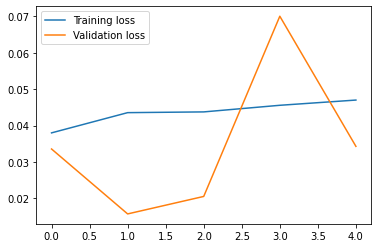

In [45]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [34]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

[Timestamp('2023-01-03 00:00:00', freq='C'), Timestamp('2023-01-04 00:00:00', freq='C'), Timestamp('2023-01-05 00:00:00', freq='C'), Timestamp('2023-01-06 00:00:00', freq='C'), Timestamp('2023-01-09 00:00:00', freq='C'), Timestamp('2023-01-10 00:00:00', freq='C'), Timestamp('2023-01-11 00:00:00', freq='C'), Timestamp('2023-01-12 00:00:00', freq='C'), Timestamp('2023-01-13 00:00:00', freq='C'), Timestamp('2023-01-17 00:00:00', freq='C'), Timestamp('2023-01-18 00:00:00', freq='C'), Timestamp('2023-01-19 00:00:00', freq='C'), Timestamp('2023-01-20 00:00:00', freq='C'), Timestamp('2023-01-23 00:00:00', freq='C'), Timestamp('2023-01-24 00:00:00', freq='C')]
1/1 [==============================] - 0s 269ms/step


In [35]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

<ipython-input-36-741a8c44d1af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation

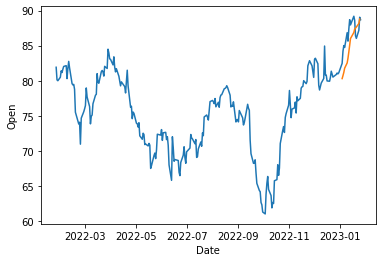

In [36]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])